In [2]:
import torch
import numpy as np
from torch import nn
import tensorly as tl
from tqdm import tqdm
import matplotlib.pyplot
from torch.optim import Adam
from torch.utils.data import DataLoader

In [5]:
tl.set_backend('pytorch')

In [6]:
data_dir = 'data/'

In [8]:
BATCH_SIZE = 32

In [10]:
import pandas as pd
data = pd.read_csv(data_dir + 'diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [11]:
len(data)

768

In [12]:
target = np.matrix(data['Outcome']).T
input = np.matrix(data.drop('Outcome', axis=1))

train_input = torch.from_numpy(input[:-100]).type(torch.FloatTensor).cuda()
train_target = torch.from_numpy(target[:-100]).type(torch.FloatTensor).cuda()

test_input = torch.from_numpy(input[-100:]).type(torch.FloatTensor).cuda()
test_target = torch.from_numpy(target[-100:]).type(torch.FloatTensor).cuda()

In [45]:
NN = TensorNet(3, input.shape[1], 100, target.shape[1], 15).cuda()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [46]:
loss = nn.BCELoss()
optimizer = Adam(NN.parameters(), lr=0.001)

In [47]:
train_dataset = torch.utils.data.TensorDataset(train_input, train_target)
test_dataset = torch.utils.data.TensorDataset(test_input, test_target)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [53]:
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

def balanced_accuracy(Y, Y_hat):
    Y_hat[Y_hat > 0.5] = 1
    Y_hat[Y_hat <= 0.5] = 0
    return balanced_accuracy_score(Y, Y_hat)

In [54]:
hist = NN.fit(train_loader, loss, optimizer, 1000, test_loader, {'balanced_accuracy': balanced_accuracy, 'ROC-AUC': roc_auc_score})

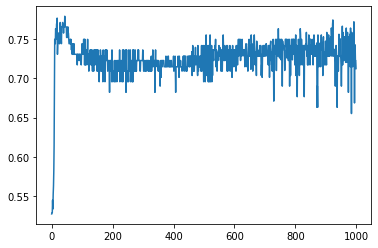

In [51]:
plt.plot(np.arange(len(hist['balanced_accuracy'])), hist['balanced_accuracy'])

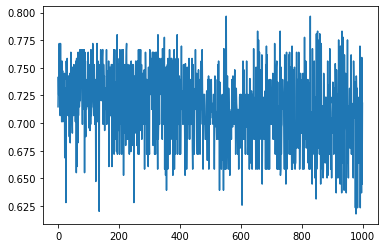

In [55]:
plt.plot(np.arange(len(hist['ROC-AUC'])), hist['ROC-AUC'])